In [39]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from Data import Data
from datetime import datetime

from gluonts.dataset.common import ListDataset

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [37]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [40]:
d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [52]:
result.shape

(841, 635)

In [53]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }

In [54]:
data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

In [50]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat

In [56]:
target.shape

(100, 168)

In [59]:
feat_static_cat.shape

(100,)

In [62]:
result.shape

(841, 635)

In [8]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


In [11]:
dataset = get_dataset("m4_hourly", regenerate=True)

INFO:root:downloading and processing m4_hourly


saving time-series into /home/mathsys2/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /home/mathsys2/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


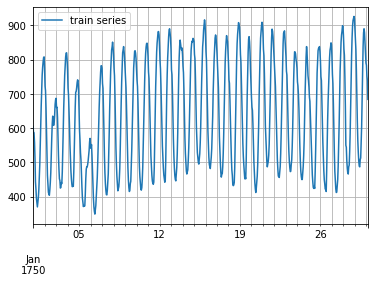

In [12]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

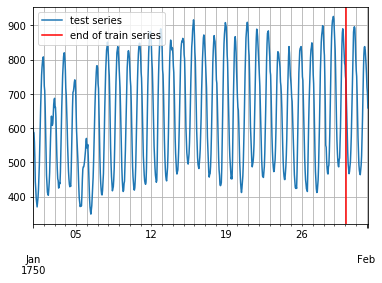

In [15]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [16]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [17]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series


In [20]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start}
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start}
                       for x in custom_dataset],
                      freq=freq)

In [25]:
train_ds.list_data

[{'target': array([-1.1968393e+00,  5.9665781e-01,  1.6804966e+00,  1.2153275e+00,
         -2.1455821e-01, -1.0560429e+00,  1.2048380e+00, -8.8918078e-01,
         -2.2146674e-01, -3.3699116e-01,  1.1430941e-01, -3.7454838e-01,
          8.2614374e-01,  5.8715624e-01,  2.2086972e-01,  1.8132350e+00,
          5.9160286e-01, -3.3875305e-02, -1.2241485e+00, -1.2595674e+00,
         -4.6357137e-01,  1.6225000e-01,  6.1412513e-01, -1.8038042e-01,
          5.0981319e-01,  1.1616563e-01, -5.9715492e-01, -9.5811808e-01,
          2.1697740e-01, -5.5396430e-02,  7.6488411e-01, -1.3464490e-01,
         -2.0658648e+00,  1.6874652e-02,  2.6071159e-02, -1.2326601e-02,
         -4.4139057e-01, -6.7060333e-01,  1.4232586e-01,  2.3029563e+00,
         -3.8236398e-02,  1.6356477e+00, -1.4360933e-01, -1.9079082e-01,
          9.5100009e-01, -3.7830210e-01,  3.3754343e-01, -1.1734073e+00,
          5.5062729e-01,  1.5528926e-01, -1.0890330e+00,  6.8219513e-02,
         -7.2322273e-01,  7.2319716e-01, 

INFO:root:Using CPU


In [27]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [28]:

predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 48513


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 117.25it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[0] Elapsed time 0.855 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.473263
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 100.64it/s, avg_epoch_loss=4.86]
INFO:root:Epoch[1] Elapsed time 0.995 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.859863
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 123.71it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[2] Elapsed time 0.810 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.619222
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 136.33it/s, avg_epoch_loss=4.56]
INFO:root:Epoch[3] Elapsed time 0.735 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.557225
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 112.53it/s, avg_epoch_loss=4.74]
INFO:root:Epoch[4] Elapsed time 0.890 seconds
INFO:r

In [34]:
dataset.train.is_valid

<function gluonts.dataset.common.FileDataset.is_valid(path:pathlib.Path) -> bool>